# Data Science - Laboratorio 3
## Modelos Long-Short Term Memory (LSTM)
- - -
### Integrantes:
- Diego Alberto Leiva 21752
- José Pablo Orellana 21970
- - -

### Librerias

In [1]:
# Manipulacion de Datos
import pandas as pd
import numpy as np

# Sistema
import os

# Utilidades
import random

# Visualizacion
import matplotlib.pyplot as plt

# Preprocesamiento
from sklearn.preprocessing import StandardScaler


# PyTorch CUDA
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

### Carga de Datasets

In [2]:
# Leer los archivos de una carpeta y almacenarlos como dataframes
consumos = pd.read_csv('data/consumos_combustibles.csv', sep=';', encoding='utf-8')
importaciones = pd.read_csv('data/importaciones_combustibles.csv', sep=';', encoding='utf-8')
precios = pd.read_csv('data/precios_combustibles.csv', sep=';', encoding='utf-8')

data_frames = {
    'Consumos': consumos,
    'Importaciones': importaciones,
    'Precios': precios
}

# Mostrar los nombres de los archivos
print(f"Se cargaron un total de 3 archivos\n")
print('Archivos cargados:')
for key in data_frames.keys():
    print(f"\t- {key}")

Se cargaron un total de 3 archivos

Archivos cargados:
	- Consumos
	- Importaciones
	- Precios


## Preprocesamiento

### Seleccion de Variables

Solo se tomarán en cuenta los datos de importación, consumo y precios de los siguientes tipos de combustibles:
- `Gasolina Súper`
- `Gasolina Regular`
- `Diesel` -> combinacion de Diesel alto azufre y bajo azufre
- `Gas Propano`

In [3]:
# Seleccionar las columnas de interés para consumos e importaciones
cols = ['Fecha','Gasolina regular', 'Gasolina superior', 'Diesel alto azufre', 'Diesel bajo azufre', 'Gas licuado de petróleo']

# Filtrar columnas en 'consumo_combustibles'
consumos = consumos[cols].copy()

# Filtrar columnas en 'importacion_combustibles'
importaciones = importaciones[cols].copy()

# Filtrar columnas en 'precios_combustibles'
precios_cols = ['FECHA','Superior GTQ/GALON', 'Regular GTQ/GALON', 'Diesel GTQ/GALON', 'Glp Cilindro 25Lbs GTQ/LB']
precios = precios[precios_cols].copy()

### Verificacion y manejo de Nulos

En el laboratorio anterior se encontro que Ceras y tipo cambio eran las variables con nulos. Dado que ahora se seleccionaron las variables de interes antes, es probable que ya no existan nulos.

In [4]:
# Comprobar si hay valores nulos
print("Valores nulos en el dataset de consumo de combustibles:", consumos.isnull().sum().sum())
print("Valores nulos en el dataset de importación de combustibles:", importaciones.isnull().sum().sum())
print("Valores nulos en el dataset de precios de combustibles:", precios.isnull().sum().sum())

Valores nulos en el dataset de consumo de combustibles: 0
Valores nulos en el dataset de importación de combustibles: 0
Valores nulos en el dataset de precios de combustibles: 0


### Manejo de Fechas

Anterormente se encontro que los 3 datasets contienen una unica variable culitativa la cual es `Fecha`. Esta se encuentra como string por lo que se debe de transformar a datetime

In [5]:
# Diccionario de meses en español a inglés
month_mapping = {
    'ene': 'Jan',
    'feb': 'Feb',
    'mar': 'Mar',
    'abr': 'Apr',
    'may': 'May',
    'jun': 'Jun',
    'jul': 'Jul',
    'ago': 'Aug',
    'sep': 'Sep',
    'oct': 'Oct',
    'nov': 'Nov',
    'dic': 'Dec'
}

# Función para reemplazar los nombres de los meses
def replace_months(date_str):
    for esp, eng in month_mapping.items():
        date_str = date_str.replace(esp, eng)
    return date_str

# Por fines practicos, se renombra la columna  'FECHA' a 'Fecha' en el dataset de precios de combustibles
precios.rename(columns={'FECHA': 'Fecha'}, inplace=True)

# Aplicar la función a las columnas de fecha de los dataframes
consumos['Fecha'] = consumos['Fecha'].apply(replace_months)
importaciones['Fecha'] = importaciones['Fecha'].apply(replace_months)
precios['Fecha'] = precios['Fecha'].apply(replace_months)

# Convertir las columnas de fecha a datetime
consumos['Fecha'] = pd.to_datetime(consumos['Fecha'], format='%b/%Y')
importaciones['Fecha'] = pd.to_datetime(importaciones['Fecha'], format='%b/%Y')
precios['Fecha'] = pd.to_datetime(precios['Fecha'], format='%d/%b/%Y')

# Establecer la columna 'Fecha' como índice en los tres dataframes
consumos.set_index('Fecha', inplace=True)
importaciones.set_index('Fecha', inplace=True)
precios.set_index('Fecha', inplace=True)

# Converir los indices a datetime
consumos.index = pd.to_datetime(consumos.index)
importaciones.index = pd.to_datetime(importaciones.index)
precios.index = pd.to_datetime(precios.index)

# Ordenar los índices
consumos.sort_index(inplace=True)
importaciones.sort_index(inplace=True)
precios.sort_index(inplace=True)

# Inferir la frecuencia de los índices
pd.infer_freq(consumos.index)
pd.infer_freq(importaciones.index)
pd.infer_freq(precios.index);

### Manejo de variables Diesel

Es necesario combinar ambas variables de diesel en una unica variable donde las fechas de antes del 2018 se tomaran para el diesel alto en azufre, posterior a 2018 se tomaran las de diesel alto en azufre.

In [6]:
def combine_diesel(df, high_sulfur_col, low_sulfur_col, combined_col):
    """
    Función que combina las columnas de Diesel de alto y bajo azufre en una sola columna.
    Toma los valores de Diesel de alto azufre hasta 2017 y los de Diesel de bajo azufre a partir de 2018.

    Args:
        df (pandas.DataFrame): El dataframe de entrada.
        high_sulfur_col (str): El nombre de la columna de Diesel de alto azufre.
        low_sulfur_col (str): El nombre de la columna de Diesel de bajo azufre.
        combined_col (str): El nombre de la nueva columna combinada.
    
    Returns:
        data (pandas.DataFrame): El dataframe de entrada con la nueva columna combinada.
    """
    # Crear una copia del dataframe
    data = df.copy()

    # Crear una nueva columna con los valores de Diesel de alto azufre
    data.loc[data.index < '2018-01-01', combined_col] = data[high_sulfur_col]
    data.loc[data.index >= '2018-01-01', combined_col] = data[low_sulfur_col]

    # Eliminar las columnas originales
    data.drop(columns=[high_sulfur_col, low_sulfur_col], inplace=True)

    return data

In [7]:
# Combina las columnas de Diesel de alto y bajo azufre en una sola columna
consumos = combine_diesel(consumos, 'Diesel alto azufre', 'Diesel bajo azufre', 'Diesel')
importaciones = combine_diesel(importaciones, 'Diesel alto azufre', 'Diesel bajo azufre', 'Diesel')

### Renombrar Variables

Por fines practicos se renombraran las variables

In [8]:
precios.rename(columns={
    'Superior GTQ/GALON': 'Gasolina Superior',
    'Regular GTQ/GALON': 'Gasolina Regular',
    'Diesel GTQ/GALON': 'Diesel',
    'Glp Cilindro 25Lbs GTQ/LB': 'Gas Propano'
}, inplace=True)

# Renombrar columnas en 'consumo_combustibles'
consumos.rename(columns={
    'Gasolina regular': 'Gasolina Regular',
    'Gasolina superior': 'Gasolina Superior',
    'Gas licuado de petróleo': 'Gas Propano'
}, inplace=True)

# Renombrar columnas en 'importacion_combustibles'
importaciones.rename(columns={
    'Gasolina regular': 'Gasolina Regular',
    'Gasolina superior': 'Gasolina Superior',
    'Gas licuado de petróleo': 'Gas Propano'
}, inplace=True)

## Modelos LSTM

### Configuracion de PyTorch con CUDA

In [9]:
# Configuración de la GPU
os.environ['CUDA_PATH'] = r"C:/Program Files/NVIDIA GPU Computing Toolkit//CUDA//v12.4"  # Ruta para CUDA 12.4

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    print(f"CUDA AVAILABLE")

    print(f"Using: {torch.cuda.get_device_name(torch.cuda.current_device())}")
    # Configurar el generador de números aleatorios de CUDA
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Multi-GPU.

    # Configurar el dispositivo de PyTorch para usar la GPU
    device = torch.device("cuda")

    # Configurar PyTorch a determinista
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
else:
    # Si no hay GPU disponible, usar la CPU
    print("CUDA NOT AVAILABLE")
    print("Using CPU")
    device = torch.device("cpu")

CUDA AVAILABLE
Using: NVIDIA GeForce RTX 3070 Ti Laptop GPU


### Transformacion de Dataframes a Numpy Array

(293, 1)


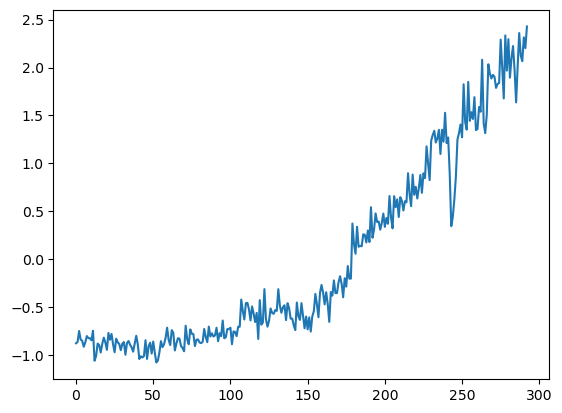

In [10]:
df = consumos.copy()
timeseries = df[['Gasolina Regular']].values.astype(float)
scaler = StandardScaler()
timeseries = scaler.fit_transform(timeseries)

print(timeseries.shape)
plt.plot(timeseries)
plt.show()

### Split de datos

In [11]:
test_size = 36
train_size = len(timeseries) - test_size

train_data = timeseries[:train_size]
test_data = timeseries[train_size:]

### Creacion de Tensores

In [12]:
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset[i : i + lookback]
        target = dataset[i + 1 : i + lookback + 1]
        X.append(feature)
        y.append(target)

    # Convertir listas a numpy arrays y luego a tensores
    X = np.array(X)
    y = np.array(y)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [13]:
lookback = 4
X_train, y_train = create_dataset(train_data, lookback=lookback)
X_test, y_test = create_dataset(test_data, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([253, 4, 1]) torch.Size([253, 4, 1])
torch.Size([32, 4, 1]) torch.Size([32, 4, 1])


### Definicion de Arquitectura

In [14]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTM, self).__init__()
        
        # Definir la capa LSTM
        self.lstm = nn.LSTM(input_size = input_size, 
                            hidden_size = hidden_size, 
                            num_layers = num_layers, 
                            batch_first = True)
        
        # Definir la capa de salida
        self.linear = nn.Linear(hidden_size, 
                                output_size)
        
        # Agregar una capa de activación ReLU
        self.relu = nn.ReLU() 
        
        self.hidden_size = hidden_size  # Numero de hidden states
        self.num_layers = num_layers    # Numero de capas
        

    def forward(self, x):
        # Inicializar los hidden states
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size)

        # Forward pass a la capa LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Aplicar la capa de activación
        out = self.relu(out)
        
        # Solo se necesita el último hidden state
        out = self.linear(out)
        
        return out

### Hiperparametros

In [15]:
# Definir hiperparametros del modelo
n_epochs = 100            # Numero de epochs
input_size = 1          # Tamaño de la secuencia de entrada
hidden_size = 100       # Tamaño del hidden state
num_layers = 2          # Numero de capas LSTM
output_size = 1         # Tamaño de la secuencia de salida


# Crear el modelo
model = LSTM(input_size, hidden_size, output_size, num_layers)

# Definir la función de pérdida y el optimizador
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Utilizar un DataLoader para cargar los datos
loader = data.DataLoader(data.TensorDataset(X_train, y_train), batch_size=16, shuffle=False)

### Entrenamiento

In [16]:
# Perdidas
loss_train = []
loss_test = []

# Iteramos sobre cada epoca
for epoch in range(n_epochs):
    # Colocamos el modelo en modo de entrenamiento
    model.train()
    
    # Cargamos los batches
    for X_batch, y_batch in loader:
        # Obtenemos una primera prediccion
        y_pred = model(X_batch)
        # Calculamos la perdida
        loss = loss_fn(y_pred, y_batch)
        # Reseteamos la gradiente a cero
        #   sino la gradiente de previas iteraciones se acumulará con las nuevas
        optimizer.zero_grad()
        # Backprop
        loss.backward()
        # Aplicar las gradientes para actualizar los parametros del modelo
        optimizer.step()
        
    # Validación cada 100 epocas
    if epoch % 100 != 0 and epoch != n_epochs-1:
        continue
    # Colocamos el modelo en modo de evaluación
    model.eval()
    
    # Deshabilitamos el calculo de gradientes
    with torch.no_grad():
        # Prediccion
        y_pred = model(X_train)
        # Calculo del RMSE - Root Mean Square Error
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        # Prediccion sobre validation
        y_pred = model(X_test)
        # Calculo del RMSE para validation
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
        loss_train.append(train_rmse)
        loss_test.append(test_rmse)
        
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 0.7245, test RMSE 1.9939
Epoch 99: train RMSE 0.1587, test RMSE 0.4413


### Visualizacion

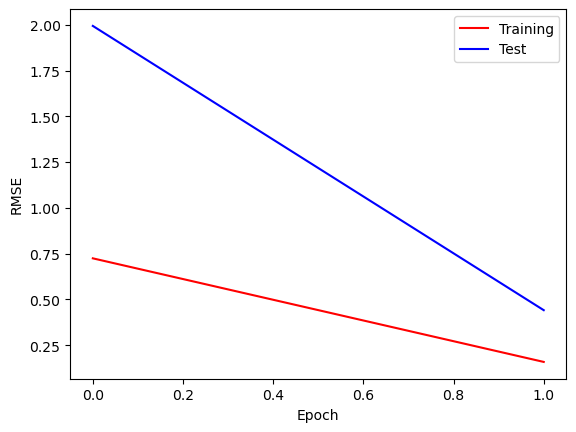

In [17]:
# Visualización del rendimiento
epoch = np.arange(len(loss_train))
plt.figure()
plt.plot(epoch, loss_train, 'r', label='Training',)
plt.plot(epoch, loss_test, 'b', label='Test')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('RMSE')
plt.show()

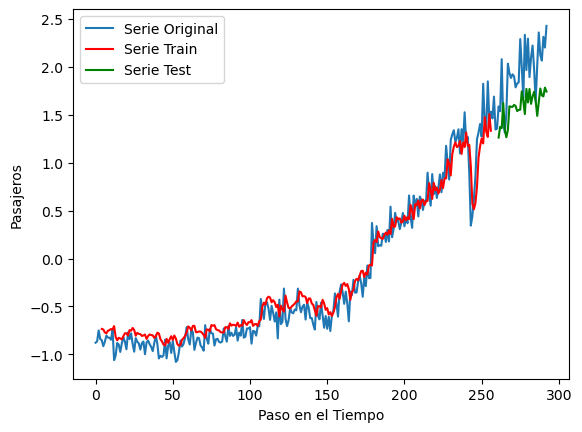

RMSE Train: 0.1587027609348297
RMSE Test: 0.4413450062274933


In [18]:
# Graficamos
with torch.no_grad():
    # Movemos las predicciones de train para graficar
    train_plot = np.ones_like(timeseries) * np.nan
    # Prediccion de train
    y_pred = model(X_train)
    # Extraemos los datos solo del ultimo paso
    y_pred = y_pred[:, -1, :]
    train_plot[lookback : train_size] = model(X_train)[:, -1, :]
    # Movemos las predicciones de test
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size + lookback : len(timeseries)] = model(X_test)[:, -1, :]

    
plt.figure()
plt.plot(timeseries, label="Serie Original")
plt.plot(train_plot, c='r', label="Serie Train")
plt.plot(test_plot, c='g', label="Serie Test")
plt.xlabel('Paso en el Tiempo'), plt.ylabel('Pasajeros')
plt.legend()
plt.show()

print(f"RMSE Train: {loss_train[-1]}")
print(f"RMSE Test: {loss_test[-1]}")